## Import used packages

In [1]:
import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import spatial
from math import sin, cos, sqrt, atan2, radians
import folium

## Import data

In [2]:
sys.path.insert(0,"..")
bremen_trips = pd.read_csv("../data/processed/trips_weather.csv", index_col=0)
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])

In [3]:
bremen_trips.head(2)

,bike,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,...,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm
0,20685,71,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,...,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0
1,20626,71,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,16260.0,8.884911,53.078923,8.884911,53.078923,...,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0


## Function that calculates distance moved towards the university of Bremen

In [4]:
# Function that calculates if start or end location is closer to University of Bremen. 
# Returns the difference of the distances of the start and end location in kilometers.
# If value positive, end locations is closer to university. That means moved towards university.
def distanceToUni(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    uLat = radians(53.1069302) # University of Bremen Latitude
    uLng = radians(8.8499603)  # University of Bremen Longitude

    sdlon = uLng - sLng
    sdlat = uLat - sLat

    edlon = uLng - eLng
    edlat = uLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(uLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(uLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

## Example of trip moving away from the university

- Red marker = University of Bremen
- Blue marker = Start location
- Green marker = End location

In [5]:
m = folium.Map(location=[53.1069302,8.8499603], zoom_start=12)

folium.Marker([53.1069302,8.8499603], popup='<i>Uni</i>',icon=folium.Icon(color='red')).add_to(m)

row = 2
folium.Marker([bremen_trips.iloc[row,7],bremen_trips.iloc[row,6]], popup='<i>Start</i>').add_to(m)
folium.Marker([bremen_trips.iloc[row,9],bremen_trips.iloc[row,8]], popup='<i>End</i>',icon=folium.Icon(color='green')).add_to(m)

print(distanceToUni(bremen_trips.iloc[row,6],bremen_trips.iloc[row,7],bremen_trips.iloc[row,8],bremen_trips.iloc[row,9]))

m

-0.6630672878488006


## Add to_uni attribute to trips data

In [6]:
to_uni = []
to_uni_dummy = []

for index, row in bremen_trips.iterrows():
    dist_to_uni = distanceToUni(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    to_uni.append(dist_to_uni)
    
    if dist_to_uni >= 0:
        to_uni_dummy.append(1)
    else:
        to_uni_dummy.append(0)
    
bremen_trips['to_uni'] = to_uni
bremen_trips['to_uni_dummy'] = to_uni_dummy

In [7]:
bremen_trips.sample(3)

,bike,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,...,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm,to_uni,to_uni_dummy
21644,20548,71,14232744,2019-04-08 13:20:00,2019-04-08 13:44:00,1440.0,8.806428,53.069693,8.805525,53.070013,...,4.7,40.0,6.7,2.2,4.8,40.0,0.0,0.0,-0.005999,0
124555,20979,71,24868302,2019-11-15 07:20:00,2019-11-15 07:23:00,180.0,8.798499,53.094396,8.798717,53.093773,...,7.4,80.0,11.0,5.1,7.4,80.0,0.0,0.0,-0.013214,0
110423,20643,71,23582910,2019-10-17 14:41:00,2019-10-17 14:54:00,780.0,8.806372,53.078147,8.784057,53.071249,...,1.6,200.0,2.6,1.0,1.8,210.0,0.0,0.0,-1.599827,0


## Check on correlations to_uni

In [8]:
bremen_trips.drop(columns={'end_lng','end_lat','end_place','end_plz','to_uni','to_uni_dummy','duration_sec','duration_min','identification'}).corrwith(bremen_trips['to_uni'])

bike                  0.000211
bike_type            -0.000414
start_lng            -0.182360
start_lat            -0.308355
start_place          -0.025935
start_plz            -0.107646
month                 0.001459
weekdays             -0.003260
temp_2m              -0.001132
humidity_2m           0.002514
dew_point_2m          0.001915
max_at_2m            -0.001046
mean_speed_h/s        0.001006
direction_degree_x    0.002561
max_m/s               0.000813
min_mean_m/s         -0.000848
max_mean_m/s          0.000691
direction_degree_y    0.001673
min                   0.004558
mm                    0.000559
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.1

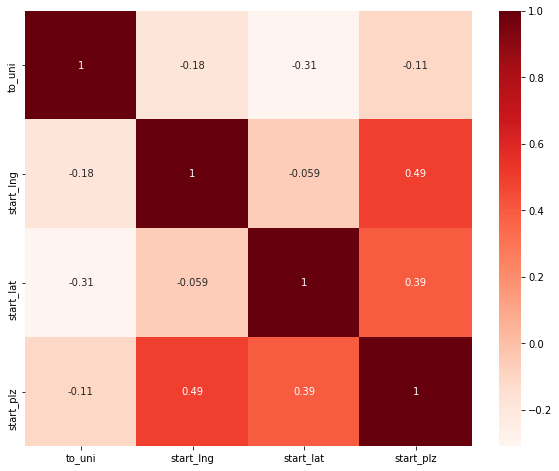

In [9]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni','start_lng','start_lat','start_plz']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Check on correlations to_uni_dummy

In [10]:
bremen_trips.drop(columns={'end_lng','end_lat','end_place','end_plz','to_uni','to_uni_dummy','duration_sec','duration_min','identification'}).corrwith(bremen_trips['to_uni_dummy'])

bike                 -0.005157
bike_type            -0.005144
start_lng            -0.132751
start_lat            -0.194404
start_place           0.046905
start_plz            -0.044664
month                -0.016325
weekdays             -0.003722
temp_2m               0.000102
humidity_2m          -0.009969
dew_point_2m         -0.007533
max_at_2m             0.000301
mean_speed_h/s        0.005069
direction_degree_x    0.001479
max_m/s               0.005172
min_mean_m/s          0.002308
max_mean_m/s          0.005425
direction_degree_y    0.000653
min                   0.008469
mm                    0.004347
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.1

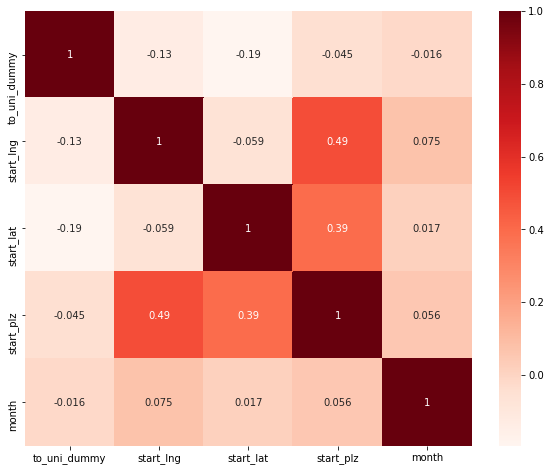

In [11]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni_dummy','start_lng','start_lat','start_plz','month']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Predicting to_uni - Regression

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [13]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz']]
y = bremen_trips['to_uni']

### Polynomial regression

In [14]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

In [15]:
poly = PolynomialFeatures(4)
X_train_poly = poly.fit_transform(X_train)

In [16]:
lin = LinearRegression()

In [17]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.23281285342958757

In [18]:
X_val_poly = poly.fit_transform(X_val)
lin.score(X_val_poly,y_val)

0.2575804962643399

In [19]:
def chooseDegree(X, y):
    
    # Splitting data into train and validation set
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

    acc_train = []
    acc_val = []
    rmses_val = []
    degrees = np.arange(1, 10)
    min_rmse, min_deg = 1e10, 0

    for deg in degrees:

        # Train features
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly_train = poly_features.fit_transform(X_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train, y_train)
        X_val_poly = poly_features.fit_transform(X_val)
        
        # Evaluate
        acc_train.append(poly_reg.score(X_poly_train, y_train))
        acc_val.append(poly_reg.score(X_val_poly,y_val))

        # Compare with val data
        poly_predict = poly_reg.predict(X_val_poly)
        poly_mse = mean_squared_error(y_val, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        rmses_val.append(poly_rmse)

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg

    # Plot and present results
    print('Best degree {} with RMSE of validation set {}'.format(min_deg, min_rmse))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    #ax_rmses_val = fig.add_subplot(111)
    axes[0].plot(degrees, rmses_val, label='rmses_val')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('RMSE')
    
    #ax_acc_train = fig.add_subplot(111)
    axes[1].plot(degrees, acc_train, label='acc_train')
    axes[1].set_yscale('linear')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Acc_train')
    axes[1].set_label('Acc_train')
    
    #ax_acc_val = fig.add_subplot(111)
    axes[1].plot(degrees, acc_val, label='acc_val')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Acc_val')
    
    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()

Best degree 4 with RMSE of validation set 1.2104183741704737


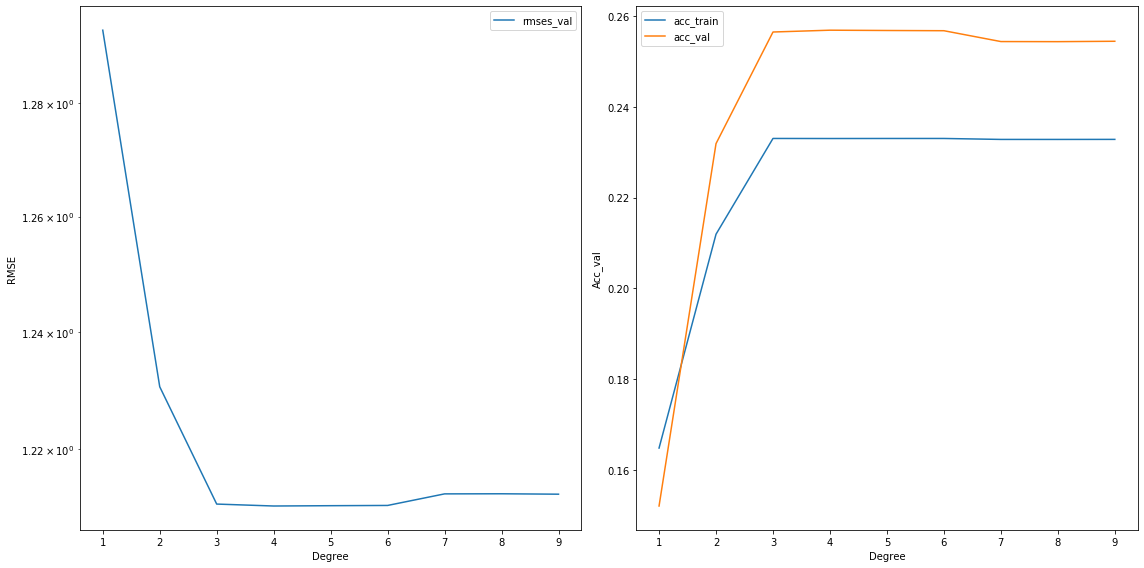

In [20]:
chooseDegree(X,y)

# Predicting to_uni_dummy - Classification

In [21]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz','month']]
y = bremen_trips['to_uni_dummy']

### Polynomial regression

Best degree 2 with RMSE of validation set 0.46936178547830015


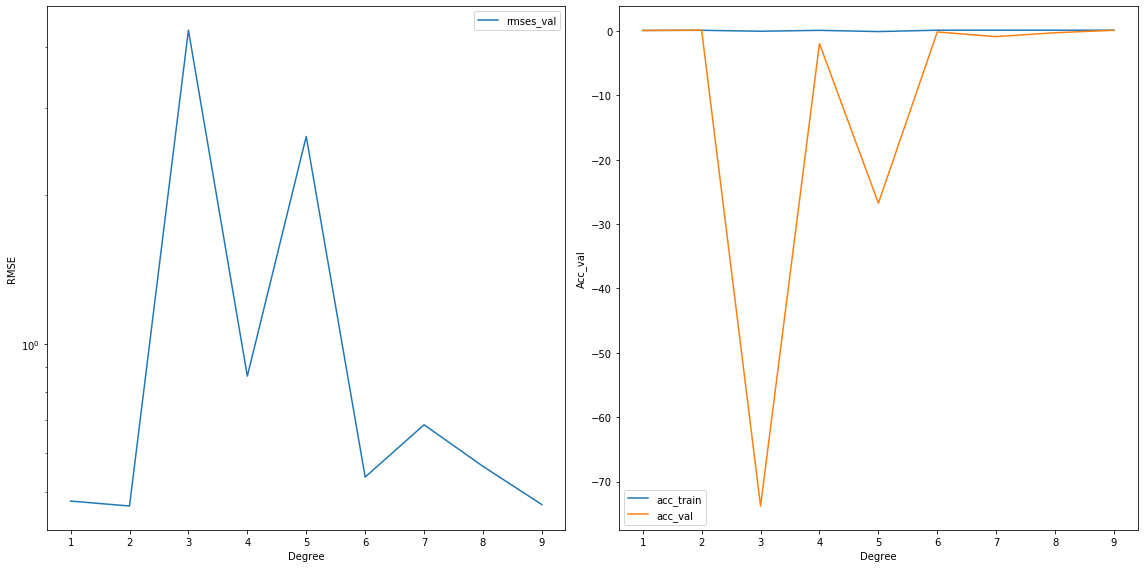

In [22]:
chooseDegree(X,y)